In [3]:
import numpy as np
from random import choice

from matplotlib import pyplot as plt
import torch

from PIL import Image
from time import time
from tqdm.notebook import tqdm

In [4]:
def generate_grid(n, m, first_part, second_part):
    grid = np.zeros((n,m))
    count = n*m
    first_count = int(first_part * count)
    second_count = int(second_part * count)

    rows, columns = np.indices((n, m))
    rows = rows.flatten()
    columns = columns.flatten()

    first_indices = np.random.choice(np.arange(len(rows)), first_count, False)
    grid[rows[first_indices], columns[first_indices]] = 1

    rows, columns = np.where(grid == 0)
    second_indices = np.random.choice(np.arange(len(rows)), second_count, False)
    grid[rows[second_indices], columns[second_indices]] = 10
    
    return grid

In [5]:
kernel = [
    [1, 1, 1],
    [1, 100, 1],
    [1, 1, 1]
]

In [6]:
def iterate(grid):
    with torch.no_grad():
        conv = convolve2d(grid.unsqueeze(0))

        # Индексы несчастных элементов первого цвета
        indices1 = torch.argwhere((conv >= 100) * (conv < 1000) * ((conv // 1) % 10 < 2))

        indices2 = torch.argwhere((conv >= 1000) * ((conv // 10) % 10 < 2))

        unhappy_cells = torch.concatenate((indices1,
                                           indices2))

        if len(unhappy_cells) == 0:
            return None

        chosen_cell = choice(unhappy_cells)

        empty_cells = torch.argwhere(grid == 0)
        empty_cell = tuple(choice(empty_cells))

        cell_value = int(grid[chosen_cell[1], chosen_cell[2]])
        grid[chosen_cell[1], chosen_cell[2]] = 0
        grid[empty_cell[0], empty_cell[1]] = cell_value

        return grid

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
conv = torch.nn.Conv2d(1, 1, (3,3), padding=1)
conv.weight = torch.nn.Parameter(torch.tensor(kernel, dtype=torch.float).reshape(conv.weight.shape))
convolve2d = conv.to(device)

In [9]:
convolve2d.weight[0][0][:]

tensor([[  1.,   1.,   1.],
        [  1., 100.,   1.],
        [  1.,   1.,   1.]], device='cuda:0', grad_fn=<SliceBackward0>)

In [11]:
def plot(grid, filename=None):
    g = np.array(grid.cpu().detach())
    g = g.copy()

    indices = np.where(g == 10)
    g[indices] = 2
    
    plt.imshow(g)
    if filename is not None:
        plt.savefig(filename)

In [46]:
grid = torch.tensor(generate_grid(1000, 1000, .25, .25), dtype=torch.float).to(device)

  0%|          | 0/1000000 [00:00<?, ?it/s]

343402


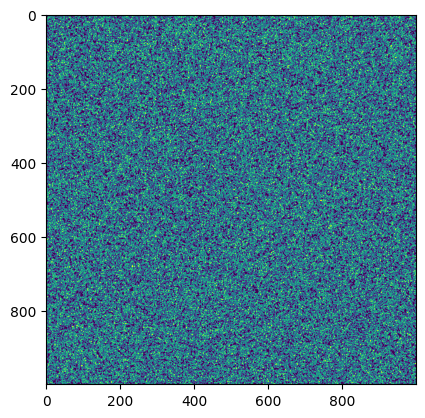

In [47]:
for i in tqdm(range(10**6)):
    if i % 10000 == 0:
        plot(grid, f'plots/{i}.png')
    if iterate(grid) is None:
        print(i)
        break

In [48]:
grid = torch.tensor(generate_grid(1000, 1000, .45, .45), dtype=torch.float).to(device)

  0%|          | 0/1000000 [00:00<?, ?it/s]

84405


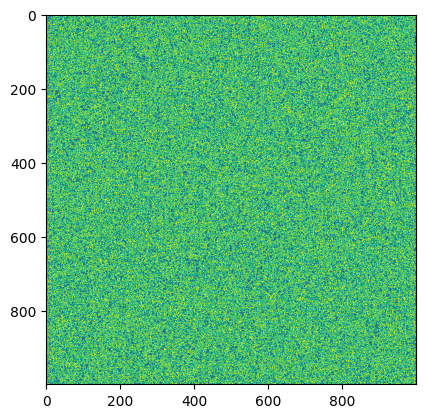

In [49]:
for i in tqdm(range(10**6)):
    if i % 10000 == 0:
        plot(grid, f'plots2/{i}.png')
    if iterate(grid) is None:
        print(i)
        break

In [50]:
grid = torch.tensor(generate_grid(200, 200, .25, .25), dtype=torch.float).to(device)

  0%|          | 0/1000000 [00:00<?, ?it/s]

14109


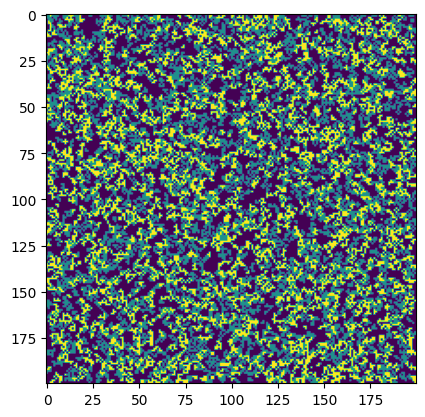

In [51]:
for i in tqdm(range(10**6)):
    if i % 1000 == 0:
        plot(grid, f'plots3/{i}.png')
    if iterate(grid) is None:
        print(i)
        break

In [52]:
grid = torch.tensor(generate_grid(2000, 2000, .25, .25), dtype=torch.float).to(device)

In [53]:
for i in tqdm(range(10**3)):
    if iterate(grid) is None:
        print(i)
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
images = [
    Image.open(f'plots3/{i*1000}.png')
    for i in range(14)
]

In [39]:
images[0].save('grid_200p25.gif', save_all=True, append_images=images[1:])